## SimSiam with ViT-S architecture with patch size=16

In [1]:
import sys
sys.path.append("../../../ssl")

In [9]:
import numpy as np
import os
import torch
import torch.nn as nn
import torchvision.transforms as Transforms
import copy
import pickle
from augmentations.loader import get_dataloaders
from utils.eval import plot_cm_roc
from utils.eval import train
from utils.eval import test_
from models.classifier import Classifier
from utils import plot_history
from utils import set_seed
set_seed(12)

In [3]:
ckpt_path = "./simsiam_vit_small_models/checkpoint.pth"
state = torch.load(ckpt_path, mmap="cpu")

### Plot for train loss vs epochs

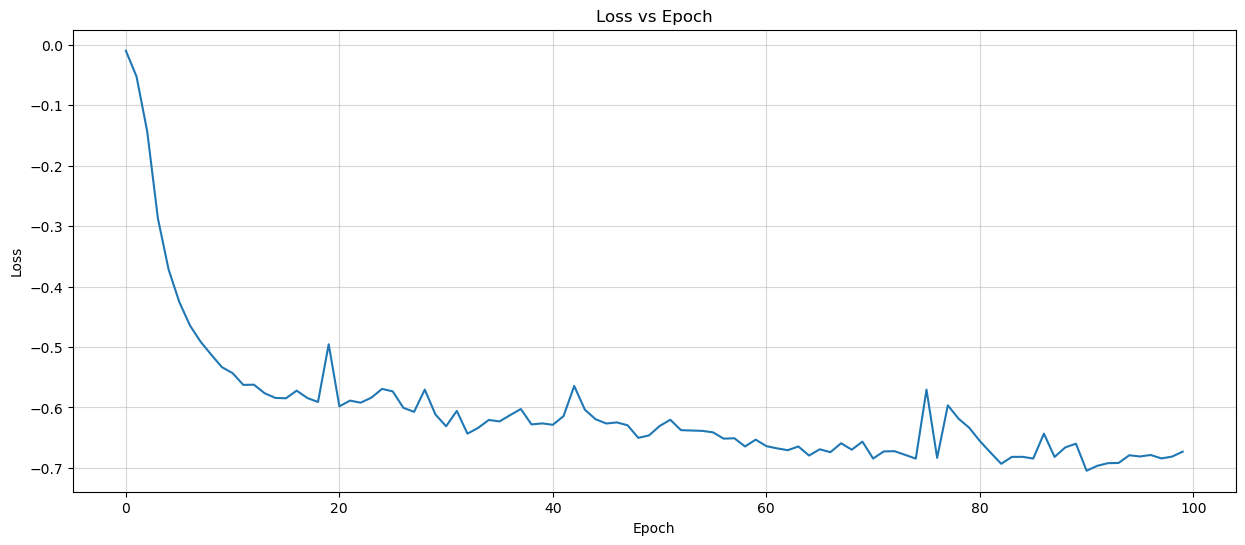

<Figure size 640x480 with 0 Axes>

In [4]:
plot_history(ckpt_path, "./train_history.png")

### Train model over the train dataset

In [5]:
set_seed(12)
eval_transforms = Transforms.Compose([
                        # Transforms.ToTensor(), # npy loader returns torch.Tensor
                        Transforms.CenterCrop(64),
                        Transforms.Normalize(mean = [0.06814773380756378, 0.21582692861557007, 0.4182431399822235],\
                                                std = [0.16798585653305054, 0.5532506108283997, 1.1966736316680908]),
                    ])
dataloader, train_loader, val_loader, test_loader \
        = get_dataloaders(data_path="../../../input/real_lenses_dataset/", \
                          train_test_indices="../../../input/indices.pkl", \
                          state=state, eval_transforms=eval_transforms)

### Finetune the pretrained model

In [10]:
set_seed(12)

student_network = torch.load("./representation_network.pth")
lp_network = Classifier(mode = "finetune", backbone = copy.deepcopy(student_network))
optimizer = torch.optim.Adam(lp_network.parameters(), lr=1e-4, weight_decay=1e-8)
num_epochs = 100
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, eta_min=1e-8)
# scheduler = None

In [11]:
set_seed(12)

lp_network, lp_network_best_loss = train(lp_network, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer, num_epochs=num_epochs, scheduler=scheduler)

[1/100] Train Loss: 0.6588, Val Loss: 0.6734, Val Accuracy: 65.87%

[2/100] Train Loss: 0.5254, Val Loss: 0.3988, Val Accuracy: 84.52%

[3/100] Train Loss: 0.3435, Val Loss: 0.3093, Val Accuracy: 87.10%

[4/100] Train Loss: 0.2977, Val Loss: 0.3532, Val Accuracy: 85.12%

[5/100] Train Loss: 0.3192, Val Loss: 0.3018, Val Accuracy: 85.91%

[6/100] Train Loss: 0.2486, Val Loss: 0.2770, Val Accuracy: 87.70%

[7/100] Train Loss: 0.2265, Val Loss: 0.2517, Val Accuracy: 88.89%

[8/100] Train Loss: 0.2025, Val Loss: 0.2571, Val Accuracy: 88.89%

[9/100] Train Loss: 0.1913, Val Loss: 0.2578, Val Accuracy: 88.89%

[10/100] Train Loss: 0.1774, Val Loss: 0.2464, Val Accuracy: 89.09%

[11/100] Train Loss: 0.2530, Val Loss: 0.2548, Val Accuracy: 87.50%

[12/100] Train Loss: 0.2111, Val Loss: 0.3325, Val Accuracy: 86.11%

[13/100] Train Loss: 0.2153, Val Loss: 0.2443, Val Accuracy: 90.48%

[14/100] Train Loss: 0.1859, Val Loss: 0.2299, Val Accuracy: 89.68%

[15/100] Train Loss: 0.1556, Val Loss: 0.24

### Test scores when the model is run on the test dataset 

In [12]:
from utils.eval import test_
output, y_true, acc, auc = test_(lp_network, test_loader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       260        |          33         |
| true nonlenses |        17        |         283         |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 91.5683% |
|    loss   |  0.0000  |
| auc score |  0.9703  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9386  | 0.8874 |  0.9123 |   293   |
|   nonlenses    |   0.8956  | 0.9433 |  0.9188 |   300   |
| macro averaged |   0.9171  | 0.9154 |  0.9156 |         |
+----------------+-----------+--------+---------+---------+


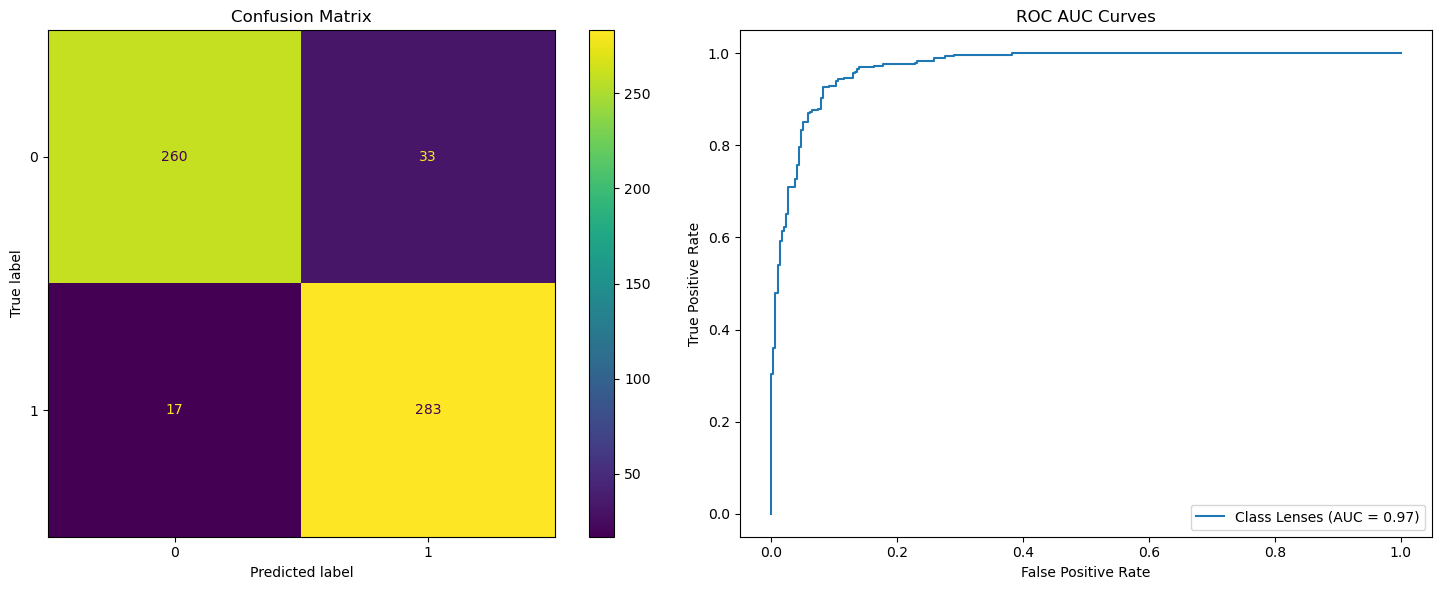

In [13]:
plot_cm_roc(output, y_true)

### Test scores when the model is run on the entire dataset 

In [14]:
output, y_true, acc, auc = test_(lp_network, dataloader, nn.CrossEntropyLoss())

Evaluation on held out test dataset
Confusion Matrix
+----------------+------------------+---------------------+
|                | predicted lenses | predicted nonlenses |
+----------------+------------------+---------------------+
|  true lenses   |       1894       |          55         |
| true nonlenses |        44        |         1956        |
+----------------+------------------+---------------------+
Test Metrics
+-----------+----------+
|  accuracy | 97.4930% |
|    loss   |  0.0042  |
| auc score |  0.9947  |
+-----------+----------+
+----------------+-----------+--------+---------+---------+
|                | precision | recall | f-score | support |
+----------------+-----------+--------+---------+---------+
|     lenses     |   0.9773  | 0.9718 |  0.9745 |   1949  |
|   nonlenses    |   0.9727  | 0.9780 |  0.9753 |   2000  |
| macro averaged |   0.9750  | 0.9749 |  0.9749 |         |
+----------------+-----------+--------+---------+---------+


In [15]:
with open("./classifier_network.pth", "wb") as f:
    pickle.dump(lp_network, f)